In [308]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

In [309]:
import re
import string
import nltk
import contractions
#from contractions import contractions_dict
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize, sent_tokenize 

[nltk_data] Downloading package stopwords to C:\Users\Phoebe-
[nltk_data]     Research\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Phoebe-
[nltk_data]     Research\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load the data

In [313]:
train_csv = pd.read_csv('train.csv', error_bad_lines=False).fillna(' ')
test_csv = pd.read_csv('test.csv', error_bad_lines=False).fillna(' ')
train = train_csv
test = pd.merge(test_csv, test_label_csv.rename(columns={'id':'id'}), on='id',  how='left')

# Get indexes with unscored data
indexes = test[ test['toxic'] == -1 ].index
test.drop(indexes , inplace=True)

In [314]:
display(test.head())
display(train.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# AGGREATE TOXIC LABELS

In [315]:
train['general_toxic'] = ((train['toxic'] + train['severe_toxic'] + train['obscene'] + train['threat'] + train['insult'] + train['identity_hate']) > 0).astype(int)
train = train.drop(columns=['toxic', 'severe_toxic', 'threat', 'insult', 'identity_hate', 'obscene','identity_hate', 'id'])
display(train[200:250].head())

test['general_toxic'] = ((test['toxic'] + test['severe_toxic'] + test['obscene'] + test['threat'] + test['insult'] + test['identity_hate']) > 0).astype(int)
test = test.drop(columns=['toxic', 'severe_toxic', 'threat', 'insult', 'identity_hate', 'obscene','identity_hate', 'id'])
test = test.reset_index(drop=True)
display(test[200:250].head()) 


,comment_text,general_toxic
200,"""\n\n Link to Sacramento \n\nI placed a wikipe...",0
201,Your blatant POV pushing \n\nNeither of you gu...,1
202,"""\nReliable sources indicate otherwise. Please...",0
203,"I did research thank you very much, and it is ...",0
204,"""\n\nA """"TotallyDisputed"""" notice would probab...",0


,comment_text,general_toxic
200,"==WARNING== \n\n This is your first warning, ...",1
201,"Red Tape, Bureaucracy, Corruption, Political c...",0
202,"""==Japan-only media== \n Eaglestorm and Dandy ...",0
203,== Freeway 2 == \n\n Definitely one of the mos...,0
204,""" """"His paternal great-great-grandmother was a...",0


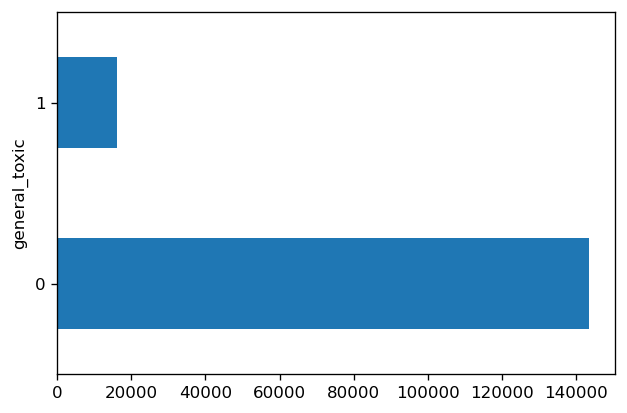

In [316]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4), dpi=120)
train.groupby('general_toxic')['general_toxic'].count().plot(kind='barh', ax=ax)

# Preprocessing

### Defining Functions

In [317]:
import contractions
import re
import unicodedata
import string

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
#https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
import bleach

def remove_links(text):
    return re.sub(r'http\S+', ' ', text)
def remove_special_characters(text):
    return re.sub(r'[^a-zA-z0-9.,!?/:;\"\'\s]', '', text)
def remove_numbers(text):
    return re.sub(r'[^a-zA-z.,!?/:;\"\'\s]' , '', text)
def remove_extra_white_spaces(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

def convert_accented_characters(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
def expand_contractions(text):
    return contractions.fix(text)

def lowercase(text):
    return ''.join(word.lower() for word in text)
def remove_punc(text):
    return ''.join([word for word in text if word not in string.punctuation])

def lemmatize_and_filter_by_pos(text):
    new_text = []
    for word, tag in pos_tag(word_tokenize(text)):
        if word not in stopwords:
            if tag.startswith("NN"):
                new_text.append(lemmatizer.lemmatize(word, pos='n'))
            elif tag.startswith('VB'):
                new_text.append(lemmatizer.lemmatize(word, pos='v'))
            elif tag.startswith('JJ'):
                new_text.append(lemmatizer.lemmatize(word, pos='a'))
    return ' '.join(new_text)

In [318]:
sample = 'Link to Sacramento I placed a wikipedialink in this article where the word ""Sacramento"" appears. Another editor, who appears to be stalking me and is reverting everything that I do, claims that I am ""overlinking"" by doing this. I have read the policy, and think I understand it, and I disagree with him. The word ""Sacramento"" was not linked anywhere else in this article before I made the link, and I think that my link provided good context for a reader who did not know Walnut Creek but thought that maybe they knew Sacramento. Was there anything wrong with my link? I would like someone objective to give their opinions.'
print(lemmatize_and_filter_by_pos(sample))

Link Sacramento place wikipedialink article word Sacramento appear editor appear stalk revert everything claim overlinking read policy think understand disagree word Sacramento link article make link think link provide good context reader know Walnut Creek think know Sacramento Was anything wrong link like someone objective give opinion


#### CLEANING TEXT

In [319]:
#training set
train['clean'] = train['comment_text'].apply(lambda text: remove_links(text))
train['clean'] = train['clean'].apply(lambda text: convert_accented_characters(text))
train['clean'] = train['clean'].apply(lambda text: remove_special_characters(text))
train['clean'] = train['clean'].apply(lambda text: remove_numbers(text))
train['clean'] = train['clean'].apply(lambda text: remove_punc(text))
train['clean'] = train['clean'].apply(lambda text: remove_extra_white_spaces(text))
display(train[200:250].head()) 

,comment_text,general_toxic,clean
200,"""\n\n Link to Sacramento \n\nI placed a wikipe...",0,Link to Sacramento I placed a wikipedialink in...
201,Your blatant POV pushing \n\nNeither of you gu...,1,Your blatant POV pushing Neither of you guys h...
202,"""\nReliable sources indicate otherwise. Please...",0,Reliable sources indicate otherwise Please do ...
203,"I did research thank you very much, and it is ...",0,I did research thank you very much and it is n...
204,"""\n\nA """"TotallyDisputed"""" notice would probab...",0,A TotallyDisputed notice would probably be app...


In [320]:
#test set
test['clean'] = test['comment_text'].apply(lambda text: remove_links(text))
test['clean'] = test['clean'].apply(lambda text: convert_accented_characters(text))
test['clean'] = test['clean'].apply(lambda text: remove_special_characters(text))
test['clean'] = test['clean'].apply(lambda text: remove_numbers(text))
test['clean'] = test['clean'].apply(lambda text: remove_punc(text))
test['clean'] = test['clean'].apply(lambda text: remove_extra_white_spaces(text))
display(test.head()) 

,comment_text,general_toxic,clean
0,Thank you for understanding. I think very high...,0,Thank you for understanding I think very highl...
1,:Dear god this site is horrible.,0,Dear god this site is horrible
2,"""::: Somebody will invariably try to add Relig...",0,Somebody will invariably try to add Religion R...
3,""" \n\n It says it right there that it IS a typ...",0,It says it right there that it IS a type The T...
4,""" \n\n == Before adding a new product to the l...",0,Before adding a new product to the list make s...


#### NORMALIZE TEXT

In [321]:
#training set
train['clean'] = train['clean']
train['clean'] = train['clean'].apply(lambda text: expand_contractions(text))
train['clean'] = train['clean'].apply(lambda text: lowercase(text))

train['normalized'] = train['normalized'].apply(lambda text: lemmatize_and_filter_by_pos(text))
display(train[200:250]) 

,comment_text,general_toxic,clean,normalized
200,"""\n\n Link to Sacramento \n\nI placed a wikipe...",0,Link to Sacramento I placed a wikipedialink in...,link sacramento place wikipedialink article wo...
201,Your blatant POV pushing \n\nNeither of you gu...,1,Your blatant POV pushing Neither of you guys h...,blatant pov push neither guy make contribution...
202,"""\nReliable sources indicate otherwise. Please...",0,Reliable sources indicate otherwise Please do ...,reliable source indicate please insert persona...
203,"I did research thank you very much, and it is ...",0,I did research thank you very much and it is n...,research thank relevance article think reseacr...
204,"""\n\nA """"TotallyDisputed"""" notice would probab...",0,A TotallyDisputed notice would probably be app...,totallydisputed notice appropriate give depth ...
205,I've abused NOTHING. Your threats are extremel...,0,Ive abused NOTHING Your threats are extremely ...,abuse nothing threat disrespectful rule wikipe...
206,Give me a permanat block raseac....!!! remembe...,1,Give me a permanat block raseac remember me Mu...,give permanat block raseac remember muslim wor...
207,Invite\n \n\nHi! I still did not have time to ...,0,Invite Hi I still did not have time to write t...,invite hi time write article fundamental roman...
208,"I asked him a question about recall, maybe tha...",0,I asked him a question about recall maybe that...,ask question recall maybe make less troubled a...
209,says no consensus was ever reached as he rever...,0,says no consensus was ever reached as he rever...,say consensus reach revert edits


In [322]:
lol = train[['general_toxic', 'normalized']]
display(lol.head())

,general_toxic,normalized
0,0,explanation edits make username hardcore metal...
1,0,daww match colour stick thanks talk january utc
2,0,hey man try edit war guy remove relevant infor...
3,0,make real suggestion improvement wonder sectio...
4,0,sir hero chance remember page


In [256]:

train.to_csv('cleaned.csv', index=False)

In [257]:
train_cleaned = pd.read_csv('cleaned.csv')
display(train_cleaned.head())

,general_toxic,normalized
0,0,explanation edits make username hardcore metal...
1,0,daww match colour stick thanks talk january utc
2,0,hey man try edit war guy remove relevant infor...
3,0,make real suggestion improvement wonder sectio...
4,0,sir hero chance remember page


In [258]:
test['normalized'] = test['clean']
test['normalized'] = test['normalized'].apply(lambda text: expand_contractions(text))
test['normalized'] = test['normalized'].apply(lambda text: lowercase(text))
test['normalized'] = test['normalized'].apply(lambda text: lemmatize_and_filter_by_pos(text))
display(test[200:250]) 

,comment_text,general_toxic,clean,normalized
475,"==WARNING== \n\n This is your first warning, ...",1,WARNING This is your first warning If you stop...,warn first warning stop gay rap as notice
479,"Red Tape, Bureaucracy, Corruption, Political c...",0,Red Tape Bureaucracy Corruption Political corr...,red tape bureaucracy corruption political corr...
483,"""==Japan-only media== \n Eaglestorm and Dandy ...",0,Japanonly media Eaglestorm and Dandy Sephy As ...,medium eaglestorm dandy sephy wpmosam section ...
484,== Freeway 2 == \n\n Definitely one of the mos...,0,Freeway Definitely one of the most difficult m...,difficult movie watch necrophilia crack gun le...
485,""" """"His paternal great-great-grandmother was a...",0,His paternal greatgreatgrandmother was a fullb...,paternal greatgreatgrandmother fullblooded che...
487,why is this linked to Birmingham when it is pr...,0,why is this linked to Birmingham when it is pr...,link birmingham dublin
488,IMDb never actually stated Tammy Windsor and K...,0,IMDb never actually stated Tammy Windsor and K...,imdb state tammy windsor karyn kupcinet person...
493,""" \n\n == 7/1 DYK == \n\n {| class=""""messagebo...",0,DYK classmessagebox talk On July Did you know ...,dyk classmessagebox talk july know update arti...
495,vivek is a bad boy \n\n > B.Tech graduate,0,vivek is a bad boy BTech graduate,vivek bad boy btech graduate
497,someone keeps editing this page and changing t...,0,someone keeps editing this page and changing t...,someone keep edit page change track list corre...


In [305]:
test = test.drop('comment_text', axis=1)
test = test.drop('clean', axis=1)
test.to_csv('test_cleaned.csv', index=False)

KeyError: "['comment_text'] not found in axis"

In [306]:
train_cleaned = pd.read_csv('cleaned.csv')
test_cleaned = pd.read_csv('test_cleaned.csv')
display(test_cleaned.head())
display(train_cleaned.head())


,general_toxic,normalized
0,0,thank understand think revert discussion
1,0,dear god site horrible
2,0,somebody try add religion mean way people keep...
3,0,say type type institution need case level suny...
4,0,add new product list make sure relevant add ne...


,general_toxic,normalized
0,0,explanation edits make username hardcore metal...
1,0,daww match colour stick thanks talk january utc
2,0,hey man try edit war guy remove relevant infor...
3,0,make real suggestion improvement wonder sectio...
4,0,sir hero chance remember page


# Establishing the Baseline - What is the score to beat?

### Baseline 1: Base Rate

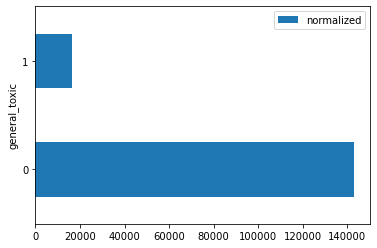

In [265]:
train_cleaned.groupby('general_toxic').count().plot(kind='barh')
#0 or non-toxic is the most frequent class

In [1]:
from sklearn.metrics import accuracy_score
baseline_pred = [0]*train_cleaned.shape[0]
base_rate = accuracy_score(y_true=train_cleaned['general_toxic'],
                           y_pred=[0]*train_cleaned.shape[0])

print(f'Baseline (Base Rate): {np.round(100*base_rate,2)}% Accuracy')


NameError: name 'train_cleaned' is not defined

### Baseline 2: Random Chance Simulation

Mean Accuracy when Using Random Labeling: 81.73%
Standard Deviation: 0.0004669251549633435


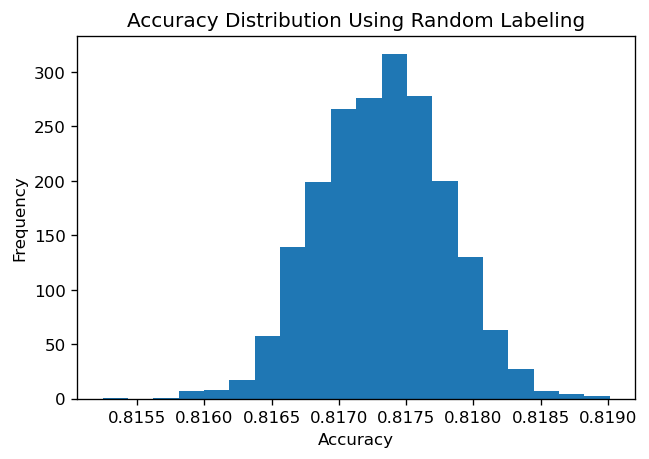

In [267]:
random_acc_results = [accuracy_score(y_true=train_cleaned['general_toxic'],
                                     y_pred=train_cleaned['general_toxic'].sample(frac=1))
                      for i in range(2000)]

fig, ax = plt.subplots(figsize=(6,4), dpi=120)
ax.hist(random_acc_results, bins=20)
ax.set_title('Accuracy Distribution Using Random Labeling')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Frequency')

print(f'Mean Accuracy when Using Random Labeling: {np.round(100*np.mean(random_acc_results),2)}%')
print(f'Standard Deviation: {np.std(random_acc_results)}')

# Pipelines

## TD-IDF

In [292]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5)
idf_train = vectorizer.fit_transform(train_cleaned['normalized'].values.astype('str'))
idf_test = vectorizer.transform(test_cleaned['normalized'].values.astype('str'))

In [293]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha':[0,1,2,3,4,5]}
model = MultinomialNB()
g_cv = GridSearchCV(model, param_grid,n_jobs=-1, scoring='f1', cv=5)
g_cv.fit(idf_train, train_cleaned['general_toxic'])
pd.DataFrame(g_cv.cv_results_)

C:\Users\Phoebe-Research\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.205850,0.027836,0.037103,0.006687,0,{'alpha': 0},0.643723,0.638290,0.652587,0.646220,0.646966,0.645557,0.004648,1
1,0.189293,0.015210,0.027129,0.000977,1,{'alpha': 1},0.604866,0.609241,0.616025,0.610984,0.601684,0.608560,0.004960,2
2,0.278078,0.080085,0.035503,0.005835,2,{'alpha': 2},0.533064,0.520616,0.528446,0.528736,0.523153,0.526803,0.004410,3
3,0.249447,0.045666,0.042521,0.017692,3,{'alpha': 3},0.461102,0.456165,0.464480,0.466070,0.452624,0.460088,0.005044,4
4,0.229698,0.026744,0.032000,0.003089,4,{'alpha': 4},0.406081,0.412714,0.409591,0.412698,0.399705,0.408158,0.004883,5
5,0.175091,0.028207,0.019002,0.005376,5,{'alpha': 5},0.364644,0.375375,0.366608,0.372839,0.359919,0.367877,0.005590,6


In [294]:
model = MultinomialNB(alpha=1)
model.fit(idf_train, train_cleaned['general_toxic'])
pred = model.predict(idf_test)
# model.fit(bow_train[-1], df_train['label'])
# pred = model.predict(bow_test[-1])

In [295]:
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

score = pd.DataFrame([(f1_score(y_true= test_cleaned['general_toxic'],
          y_pred=pred),
 fbeta_score(y_true=test_cleaned['general_toxic'],
             y_pred=pred, beta=2),
 fbeta_score(y_true=test_cleaned['general_toxic'],
             y_pred=pred, beta=0.5),
 precision_score(y_true=test_cleaned['general_toxic'],
                 y_pred=pred),
 recall_score(y_true=test_cleaned['general_toxic'],
              y_pred=pred))], columns= ['f1', 'f2','f0.5','precision','recall'], index=['tf-idf'])

In [296]:
display(score)

,f1,f2,f0.5,precision,recall
tf-idf,0.604526,0.550767,0.669914,0.721975,0.519942


## BAG OF WORDS

In [297]:
count_vec = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
bow_train = count_vec.fit_transform(train_cleaned['normalized'].values.astype('str'))
bow_test = count_vec.transform(test_cleaned['normalized'].values.astype('str'))

In [298]:
param_grid = {'alpha':[0,1,2,3,4,5]}
model = MultinomialNB()
g_cv_bow = GridSearchCV(model, param_grid, n_jobs=-1, scoring='f1', cv=5)
g_cv_bow.fit(bow_train, train_cleaned['general_toxic'])
pd.DataFrame(g_cv_bow.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.168551,0.008900,0.037101,0.003534,0,{'alpha': 0},0.679767,0.679151,0.684202,0.681256,0.685275,0.681930,0.002417,6
1,0.172974,0.008248,0.033154,0.002652,1,{'alpha': 1},0.729713,0.728935,0.727692,0.725557,0.728711,0.728122,0.001436,1
2,0.161346,0.006192,0.037159,0.004894,2,{'alpha': 2},0.722797,0.720087,0.721481,0.717207,0.726556,0.721626,0.003085,2
3,0.162881,0.005174,0.034245,0.002004,3,{'alpha': 3},0.715911,0.714898,0.715746,0.713573,0.720232,0.716072,0.002239,3
4,0.163871,0.003588,0.033184,0.006067,4,{'alpha': 4},0.709031,0.708008,0.703189,0.710323,0.716408,0.709392,0.004257,4
5,0.146521,0.003361,0.031671,0.002470,5,{'alpha': 5},0.701294,0.704197,0.696435,0.704381,0.709177,0.703097,0.004182,5


In [301]:
model_bow = MultinomialNB(alpha=1)
model_bow.fit(bow_train, train_cleaned['general_toxic'])
pred_bow = model_bow.predict(bow_test)

In [302]:
score.append(pd.DataFrame([(f1_score(y_true= test_cleaned['general_toxic'],
          y_pred=pred_bow),
 fbeta_score(y_true=test_cleaned['general_toxic'],
             y_pred=pred_bow, beta=2),
 fbeta_score(y_true=test_cleaned['general_toxic'],
             y_pred=pred_bow, beta=0.5),
 precision_score(y_true=test_cleaned['general_toxic'],
                 y_pred=pred_bow),
 recall_score(y_true=test_cleaned['general_toxic'],
              y_pred=pred_bow))], 
columns= ['f1', 'f2','f0.5','precision','recall'], index=['bow']))

,f1,f2,f0.5,precision,recall
tf-idf,0.604526,0.550767,0.669914,0.721975,0.519942
bow,0.620226,0.712430,0.549154,0.510179,0.790806


# Text Analysis

In [304]:
test_toxic = test_cleaned.loc[test_cleaned['general_toxic'] == 1
test_toxic['pred_bow'] = pred_bow
display(test_toxic[200:250])

SyntaxError: invalid syntax (<ipython-input-304-36dc8157694d>, line 2)